In [1]:
import torch
import time
from snn_delays.snn_refactored import SNN
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.utils.train_utils_refact_minimal import train, get_device, propagate_batch_simple
from snn_delays.utils.test_behavior import tb_save_max_acc_refac
import os
from snn_delays.config import DATASET_PATH
from snn_delays.datasets.custom_datasets import CustomDataset
from snn_delays.utils.memory_cached_dataset import MemoryCachedDataset
from torch.utils.data import DataLoader
import numpy as np

device = get_device()

#data = np.load(os.path.join(DATASET_PATH, 'raw_datasets', 'Letters', 'letter_classification_dataset.npz'))
data_capo = np.load(os.path.join(DATASET_PATH, 'Capocaccia', 'capocaccia.npy'))
data_random = np.load(os.path.join(DATASET_PATH, 'Capocaccia', 'randomcaccia.npy'))

# start from the first complete sample
data_capo = data_capo[29:].squeeze()
data_random = data_random[45:].squeeze()

data_capo_train = data_capo[:120*105]
data_capo_test = data_capo[120*105:][14:][:22*105]

data_random_train = data_random[:120*105]
data_random_test = data_random[120*105:][14:][:22*105]

keep, remove = 70, 35
pattern_length = keep + remove

mask = np.zeros(data_random.shape[0],)

for x in range(data_random.shape[0]):
    mask[x] = 300000 if x % pattern_length < keep else 0

mask_train = (mask == 300000)[:data_capo_train.shape[0]]
mask_test = (mask == 300000)[:data_capo_test.shape[0]]

d_c_train = data_capo_train[mask_train]
d_c_test = data_capo_test[mask_test]
d_r_train = data_random_train[mask_train]
d_r_test = data_random_test[mask_test]

n_chunks_train = 120
n_chunks_test = 22

# # concatenate the data
train_data = np.concatenate((d_c_train, d_r_train), axis=0)
test_data = np.concatenate((d_c_test, d_r_test), axis=0)

test_data = np.array(np.split(test_data, 2*n_chunks_test, axis=0))
train_data = np.array(np.split(train_data, 2*n_chunks_train, axis=0))

print(test_data.shape)
print(train_data.shape)

# create labels
train_labels = np.zeros((train_data.shape[0], 2))
test_labels = np.zeros((test_data.shape[0], 2))

for sample in range(train_data.shape[0]):
    idx = sample // n_chunks_train
    train_labels[sample, idx] = 1

for sample in range(test_data.shape[0]):
    idx = sample // n_chunks_test
    test_labels[sample, idx] = 1

num_samples = len(train_labels)

train_dataset = CustomDataset(train_data, train_labels)
test_dataset = CustomDataset(test_data, test_labels)

dataset_dict = train_dataset.get_train_attributes()

cached_train_dataset = MemoryCachedDataset(train_dataset, device=device)
cached_test_dataset = MemoryCachedDataset(test_dataset, device=device)

total_time = train_data.shape[1]
print(f'num timesteps per sample: {total_time}')

batch_size = 8

train_loader = DataLoader(cached_train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            drop_last=False,
                            pin_memory=False,
                            num_workers=0)

test_loader = DataLoader(cached_test_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            drop_last=False,
                            pin_memory=False,
                            num_workers=0)

dataset_dict["dataset_name"] = "capo_sequence"
dataset_dict["num_input"] = 2*128*128

c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on: cuda:0
(44, 70, 2, 128, 128)
(240, 70, 2, 128, 128)
Initializing GPU cache for 240 samples...
Cache initialized in 1.10 seconds
Initializing GPU cache for 44 samples...
Cache initialized in 0.08 seconds
num timesteps per sample: 70


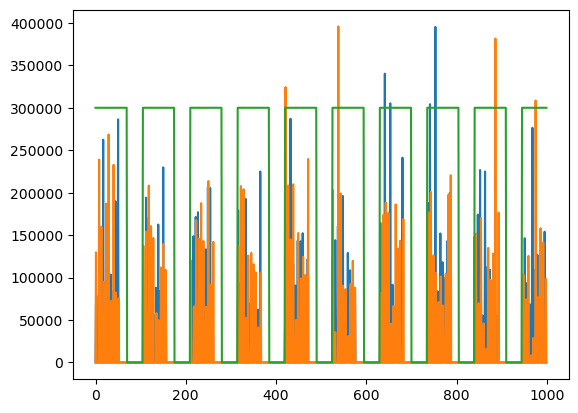

In [2]:
import matplotlib.pyplot as plt

lim1 = 0
lim2 = 1000

plt.plot(np.sum(data_capo, axis=(1, 2, 3))[lim1:lim2])
plt.plot(np.sum(data_random, axis=(1, 2, 3))[lim1:lim2])
plt.plot(mask[lim1:lim2])
#plt.plot(np.sum(data_random, axis=(1, 2, 3, 4))[0:1000])

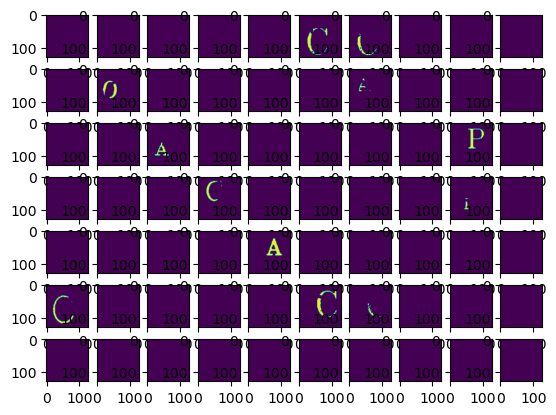

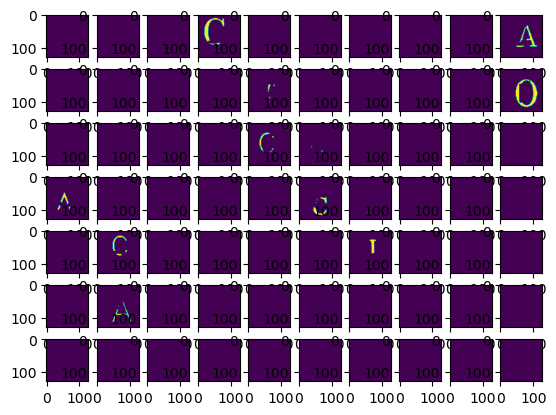

tensor([[0., 1.],
        [1., 0.]], device='cuda:0', dtype=torch.float64)


In [3]:
for img, l in train_loader:
    for b in range(2): # 2 elements of the same batch
        for x in range(70):
            plt.subplot(7, 10, x+1)
            plt.imshow(img[b, x, 0, :, :].cpu().numpy())
        plt.show()
    print(l[:2])
    break

In [4]:
dataset_dict

{'num_input': 32768,
 'num_training_samples': 240,
 'num_output': 2,
 'dataset_name': 'capo_sequence'}

In [5]:
ckpt_dir = 'capocaccia'

structure = (64, 3, 'f')
extra_kwargs = {}

snn = SNN(dataset_dict=dataset_dict, structure=structure, tau_m='log-uniform', win=total_time, loss_fn='mem_sum', batch_size=batch_size, device=device, 
          **extra_kwargs)

snn.model_name = 'capo_seq_f'
snn.set_layers()
snn.to(device)
print(snn)

num_epochs = 20
lr = 1e-3
train(snn, train_loader, test_loader, lr, num_epochs, ckpt_dir=ckpt_dir, test_behavior=tb_save_max_acc_refac, scheduler=(10, 0.95), test_every=1)


SNN(
  (criterion): CrossEntropyLoss()
  (layers): ModuleList(
    (0): FeedforwardSNNLayer(
      (linear): Linear(in_features=32768, out_features=64, bias=False)
    )
    (1-2): 2 x FeedforwardSNNLayer(
      (linear): Linear(in_features=64, out_features=64, bias=False)
    )
    (3): FeedforwardSNNLayer(
      (linear): Linear(in_features=64, out_features=2, bias=False)
    )
  )
)
Epoch [1/20], learning_rates 0.001000, 0.100000


c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Step [10/30], Loss: 3.85486
Step [20/30], Loss: 2.06068
Step [30/30], Loss: 1.60238
Time elasped: 9.508922576904297
44
Test Loss: 1.532713790734609
Avg spk_count per neuron for all 70 time-steps 245.0151515151515
Test Accuracy of the model on the test samples: 45.455

saving max acc: 45.45454545454545
Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\capocaccia
Epoch [2/20], learning_rates 0.001000, 0.100000
Step [10/30], Loss: 0.58825
Step [20/30], Loss: 1.21087
Step [30/30], Loss: 1.01260
Time elasped: 9.826426982879639
44
Test Loss: 0.9499460458755493
Avg spk_count per neuron for all 70 time-steps 248.28030303030303
Test Accuracy of the model on the test samples: 45.455

saving max acc: 45.45454545454545
Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\capocaccia
Epoch [3/20], learning_rates 0.001000, 0.100000
Step [10/30], Loss: 0.72053
Step [20/30], Loss: 0.89708
Step [30/30], Loss: 0.69914
Time elasp

In [6]:
snn_rnn = SNN(dataset_dict, structure=(64, 2, 'r'), win=total_time, tau_m='log-uniform',
               loss_fn='mem_sum', batch_size=batch_size, device=device, debug=False)

snn_rnn.set_layers()
snn_rnn.to(device)

snn_rnn.model_name = 'capo_seq_r'

print(snn_rnn)
train(snn_rnn, train_loader, test_loader, lr, num_epochs,  ckpt_dir=ckpt_dir, test_behavior=tb_save_max_acc_refac, scheduler=(10, 0.95), test_every=1)



SNN(
  (criterion): CrossEntropyLoss()
  (layers): ModuleList(
    (0): RecurrentSNNLayer(
      (linear): Linear(in_features=32768, out_features=64, bias=False)
      (linear_rec): Linear(in_features=64, out_features=64, bias=False)
    )
    (1): RecurrentSNNLayer(
      (linear): Linear(in_features=64, out_features=64, bias=False)
      (linear_rec): Linear(in_features=64, out_features=64, bias=False)
    )
    (2): FeedforwardSNNLayer(
      (linear): Linear(in_features=64, out_features=2, bias=False)
    )
  )
)
Epoch [1/20], learning_rates 0.001000, 0.100000
Step [10/30], Loss: 4.36918
Step [20/30], Loss: 4.80531
Step [30/30], Loss: 2.88383
Time elasped: 9.5903160572052
44
Test Loss: 2.1043464817727604
Avg spk_count per neuron for all 70 time-steps 312.20454545454544
Test Accuracy of the model on the test samples: 50.000

saving max acc: 50.0
Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\capocaccia
Epoch [2/20], learning_rates 0.001000,

In [8]:
extra_kwargs = {'delay_range':(50, 1),
                'pruned_delays': 3}

snn_rd = SNN(dataset_dict, structure=(64, 2, 'd'), win=total_time, tau_m='log-uniform',
               loss_fn='mem_sum', batch_size=batch_size, device=device, debug=False, **extra_kwargs)

snn_rd.set_layers()
snn_rd.to(device)

snn_rd.model_name = 'capo_seq_d'

print(snn_rd)
train(snn_rd, train_loader, test_loader, lr, num_epochs,  ckpt_dir=ckpt_dir, test_behavior=tb_save_max_acc_refac, scheduler=(10, 0.95), test_every=1)

SNN(
  (criterion): CrossEntropyLoss()
  (layers): ModuleList(
    (0): FeedforwardSNNLayer(
      (linear): Linear(in_features=32768, out_features=64, bias=False)
    )
    (1): FeedforwardSNNLayer(
      (linear): Linear(in_features=3200, out_features=64, bias=False)
    )
    (2): FeedforwardSNNLayer(
      (linear): Linear(in_features=64, out_features=2, bias=False)
    )
  )
)
Epoch [1/20], learning_rates 0.001000, 0.100000


Step [10/30], Loss: 30.04745
Step [20/30], Loss: 16.79766
Step [30/30], Loss: 0.34926
Time elasped: 9.926188945770264
44
Test Loss: 1.4723068277041118
Avg spk_count per neuron for all 70 time-steps 766.4090909090909
Test Accuracy of the model on the test samples: 61.364

saving max acc: 61.36363636363637
Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\capocaccia
Epoch [2/20], learning_rates 0.001000, 0.100000
Step [10/30], Loss: 0.79831
Step [20/30], Loss: 1.45594
Step [30/30], Loss: 1.62985
Time elasped: 10.181193113327026
44
Test Loss: 0.6165574205418428
Avg spk_count per neuron for all 70 time-steps 779.7272727272727
Test Accuracy of the model on the test samples: 70.455

saving max acc: 70.45454545454545
Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\capocaccia
Epoch [3/20], learning_rates 0.001000, 0.100000
Step [10/30], Loss: 0.76853
Step [20/30], Loss: 2.00781
Step [30/30], Loss: 0.56145
Time el

In [10]:
extra_kwargs = {'delay_range':(5, 1),
                'pruned_delays': 3}

snn_rd = SNN(dataset_dict, structure=(64, 2, 'd'), win=total_time, tau_m='log-uniform',
               loss_fn='mem_sum', batch_size=batch_size, device=device, debug=False, **extra_kwargs)

snn_rd.set_layers()
snn_rd.to(device)

snn_rd.model_name = 'capo_seq_d5'

print(snn_rd)
train(snn_rd, train_loader, test_loader, lr, num_epochs,  ckpt_dir=ckpt_dir, test_behavior=tb_save_max_acc_refac, scheduler=(10, 0.95), test_every=1, freeze_taus=True)

SNN(
  (criterion): CrossEntropyLoss()
  (layers): ModuleList(
    (0): FeedforwardSNNLayer(
      (linear): Linear(in_features=32768, out_features=64, bias=False)
    )
    (1): FeedforwardSNNLayer(
      (linear): Linear(in_features=320, out_features=64, bias=False)
    )
    (2): FeedforwardSNNLayer(
      (linear): Linear(in_features=64, out_features=2, bias=False)
    )
  )
)
Epoch [1/20], learning_rates 0.001000, 0.100000


Step [10/30], Loss: 9.30610
Step [20/30], Loss: 20.70766
Step [30/30], Loss: 27.98590
Time elasped: 11.034796237945557
44
Test Loss: 25.143397251764934
Avg spk_count per neuron for all 70 time-steps 284.79545454545456
Test Accuracy of the model on the test samples: 50.000

saving max acc: 50.0
Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\capocaccia
Epoch [2/20], learning_rates 0.001000, 0.100000
Step [10/30], Loss: 1.72136
Step [20/30], Loss: 0.08786
Step [30/30], Loss: 1.69425
Time elasped: 11.24855351448059
44
Test Loss: 5.314046621322632
Avg spk_count per neuron for all 70 time-steps 257.46590909090907
Test Accuracy of the model on the test samples: 54.545

saving max acc: 54.54545454545455
Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\capocaccia
Epoch [3/20], learning_rates 0.001000, 0.100000
Step [10/30], Loss: 15.39642
Step [20/30], Loss: 2.29421
Step [30/30], Loss: 9.11407
Time elasped: 11.8